In [1]:
import os
from  flutype_analysis import image2numeric, utils, analysis



import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.cluster import KMeans

--------------------------------------------------------------------------------
Loading data corresponding to data_id: <2018-01-24_E14_X31> in dir <../data/2018-01-24_E14_X31>
--------------------------------------------------------------------------------
Virus .gal:../data/2018-01-24_E14_X31/2018-01-24_E14_X31_vir.gal
Peptide .gal :../data/2018-01-24_E14_X31/2018-01-24_E14_X31_pep.gal
Image file  :../data/2018-01-24_E14_X31/2018-01-24_E14_X31_600_100_635.tif
Spot intensities for the data ID (2018-01-24_E14_X31) are not averaged but primary values


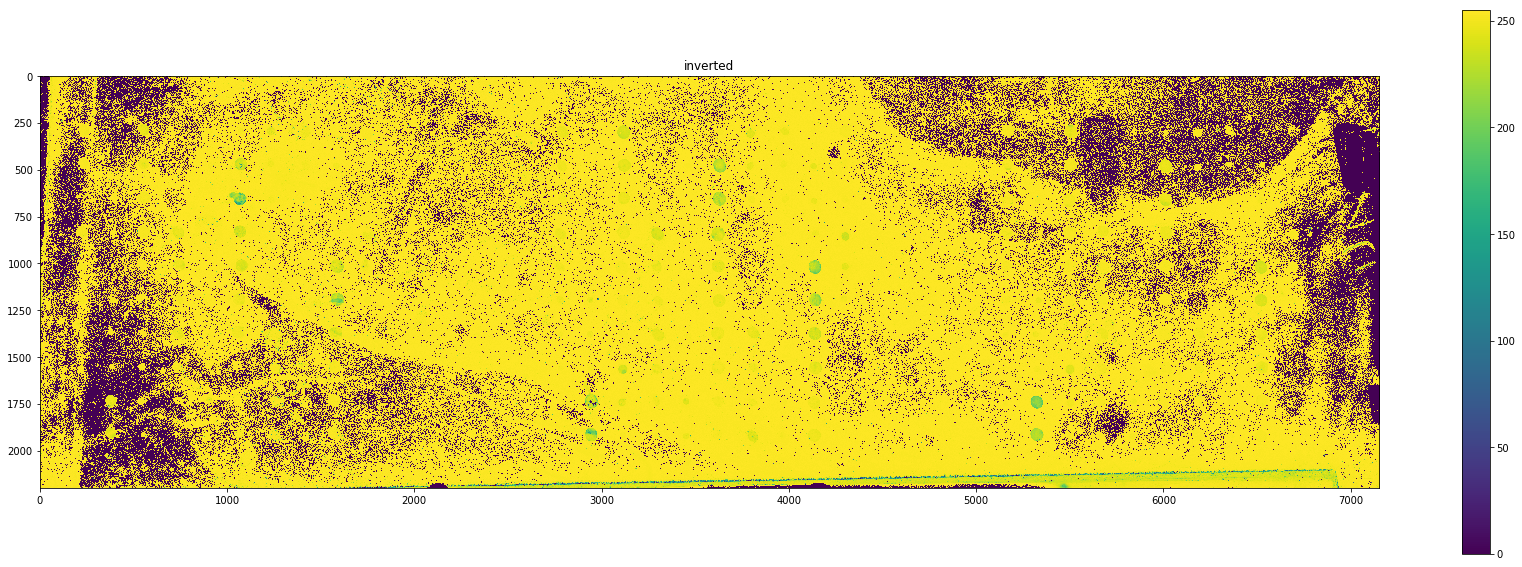

In [2]:
#data_id="2017-05-19_E5_X31"  
#data_id="2017-05-19_N5_X31"
#data_id="2017-05-19_N6_Pan"
#data_id="2017-05-19_N7_Cal"  #cannot analyse



# die guten Bilder

#data_id="2017-05-19_N9_X31" 
#data_id="2017-05-19_N10_Pan" 
#data_id="2017-05-19_N11_Cal" 
#data_id="2017-05-19_E6_untenliegend_X31"


data_id="2018-01-24_E14_X31"

#Bilder Theresa
#data_id="P6_170613_Cal" # cannot analyse






directory = os.path.join("../data",data_id)
data = utils.load_data(data_id,directory,what="image2numeric")
ana=image2numeric.Image2numeric(data)
image2numeric.draw_imag(-ana.imag.T,"inverted")


In [15]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

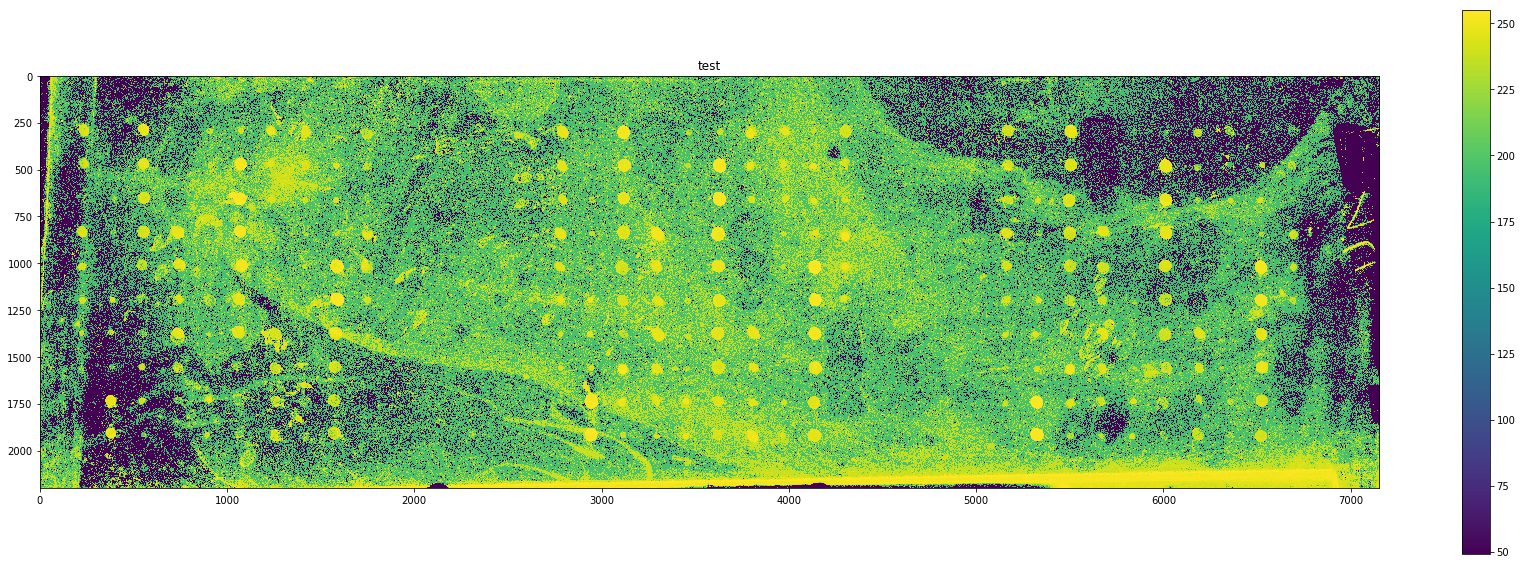

In [23]:
image2numeric.draw_imag(image_histogram_equalization(ana.imag.T)[0], 'test')


In [28]:
imag = image_histogram_equalization(ana.imag.T)[0]

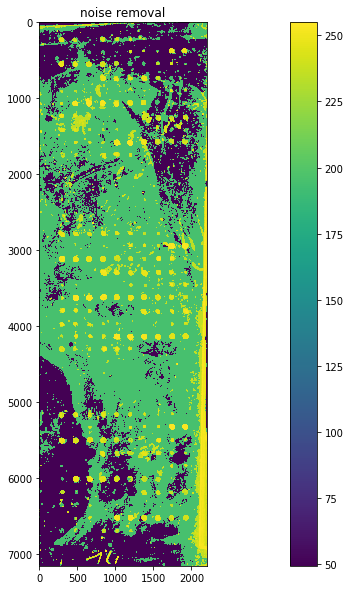

error: /io/opencv/modules/imgproc/src/distransform.cpp:718: error: (-215) src.type() == CV_8UC1 in function distanceTransform


In [40]:
#imag = ana.imag 
gray = imag.T

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(gray,cv2.MORPH_OPEN,kernel, iterations = 2)

#image2numeric.draw_imag(-gray,"inverted")
#image2numeric.draw_imag(opening,"noise removal",cmap="gray")
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=5)
image2numeric.draw_imag(sure_bg,"noise removal")
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
image2numeric.draw_imag(sure_fg,"noise removal")
unknown = cv2.subtract(sure_bg,sure_fg)

#ret, markers = cv2.connectedComponents(sure_bg)

# Add one to all labels so that sure background is not 0, but 1
#
image2numeric.draw_imag(markers,"markers")

In [ ]:
points_x = []
points_y = []
pointlist=[]
for marker in range(markers.max()):
    point= np.array(np.where(markers == marker))
    pointlist.append(len(point[0]))
    if 2*10**3 < len(point[0]) < 10**5:
        if 0.5 < image2numeric.spot_quality_shape(point[0],point[1]) < 2: 
            points_x.append(point[0].mean())
            points_y.append(point[1].mean())

gridshape = (ana.spot["Row"].max(), ana.spot["Column"].max())
    

In [ ]:
image2numeric.draw_grid(markers,points_y,points_x,"test")

In [ ]:
points_y=np.array(points_y)
points_x = np.array(points_x)

pitch = (points_y.max()-points_y.min())/(ana.spot["Row"].max()-1)

shape = (ana.spot["Row"].max(), ana.spot["Column"].max())

center_x = points_x.min()+0.5*(points_x.max()-points_x.min())
center_y = points_y.min()+0.5*(points_y.max()-points_y.min())
rotation = 0

In [ ]:
x ,y = image2numeric.spots_close_to_grid(points_x,points_y,pitch)

plt.subplots(figsize=(20,10))
plt.scatter(points_x,points_y)
plt.scatter(x+10,y+10,alpha=0.5)

plt.show()

In [ ]:
#image2numeric.draw_imag(gray,"new")
plt.subplots(figsize=(30, 10))



pitch_new = (y.max()-y.min())/(ana.spot["Row"].max()-1)

shape = (ana.spot["Row"].max(), ana.spot["Column"].max())

center_x_new = x.min()+0.5*(x.max()-x.min())
center_y_new = y.min()+0.5*(y.max()-y.min())
rotation = 0


X,Y = image2numeric.get_grid(shape, pitch_new+3, center_x_new, center_y_new, rotation)

plt.scatter(y,x,marker="x")
plt.scatter(Y,X)
plt.imshow(markers)
#estimate grid parameters 

#find closest
plt.show()


In [ ]:
first_row= ana.spot[ana.spot["Column"] == ana.spot["Column"].min()].index.tolist()
last_row= ana.spot[ana.spot["Column"] == ana.spot["Column"].max()].index.tolist()
ana.spot["X"] = 0
ana.spot["Y" ]= 0

ana.spot.set_value(first_row,"Y",Y[0])
ana.spot.set_value(last_row,"Y",Y[-1])
ana.spot.set_value(first_row,"X",X[0])
ana.spot.set_value(last_row,"X",X[-1])




rest = ana.spot.index[((ana.spot["Column"]  > 1) & ( ana.spot["Column"] <  ana.spot["Column"].max())) |
                      (ana.spot["Peptide"] == "AK 0.25")]
p_lattice= np.vstack([X, Y]).reshape(2, -1).T

ana.spot.set_value(rest,"Y",p_lattice[rest,1]+0.10*pitch_new)
ana.spot.set_value(rest,"X",p_lattice[rest,0])

rest = ana.spot.index[(ana.spot["Column"]  == 2)]

ana.spot.set_value(rest,"Y",p_lattice[rest,1]+0.10*pitch_new)
ana.spot.set_value(rest,"X",p_lattice[rest,0])

plot_patches(ana.spot["X"],ana.spot["Y"],pitch_new)

plt.imshow(markers)


plt.scatter(ana.spot['Y'],ana.spot['X'])
plt.show()

In [71]:
def plot_patches(x,y,pitch):
    fig2 = plt.figure(figsize=(30,10))
    ax2 = fig2.add_subplot(111, aspect='equal')
    pts = np.vstack([x, y]).reshape(2, -1).T
    for p in [
        patches.Rectangle(
            (patchcenter[1]-0.5*pitch, patchcenter[0]-0.5*pitch),
            pitch,
            pitch,
            fill=False,      # remove background
            linewidth=1,
            edgecolor='r'
        ) for patchcenter in pts
    ]:
        ax2.add_patch(p)
        
    return fig2

In [72]:
ana.spot["Intensity"] = 0

for index in ana.spot.index: 
    x_min = int(ana.spot.loc[index]['X']-0.5*pitch_new)
    x_max = int(ana.spot.loc[index]['X']+0.5*pitch_new)
    y_min = int(ana.spot.loc[index]['Y']-0.5*pitch_new)
    y_max = int(ana.spot.loc[index]['Y']+0.5*pitch_new)
    intensity=ana.imag[y_min:y_max,x_min:x_max].sum()
    ana.spot.set_value(index,"Intensity",intensity)

In [73]:
ana.spot.set_value(230,"Intensity",ana.spot["Intensity"][229])

,Column,Row,Peptide,Referenz,Virus,Intensity,Std,Replica,X,Y
0,1,1,Leuchtefix 1.0,True,Pan,848828,NaN,0,295.024129,681.666453
1,1,2,blank,False,Pan,3365,NaN,0,295.024129,851.894850
2,1,3,blank,False,Pan,1005,NaN,1,295.024129,1022.123248
3,1,4,blank,False,Pan,2675,NaN,2,295.024129,1192.351645
4,1,5,blank,False,Pan,4187,NaN,3,295.024129,1362.580043
5,1,6,blank,False,Pan,3434,NaN,4,295.024129,1532.808441
6,1,7,blank,False,Pan,9398,NaN,5,295.024129,1703.036838
7,1,8,Leuchtefix 1.0,True,Pan,929183,NaN,1,295.024129,1873.265236
8,1,9,blank,False,Pan,5070,NaN,6,295.024129,2043.493634
9,1,10,blank,False,Pan,3835,NaN,7,295.024129,2213.722031


In [74]:
output=ana.spot.pivot(index="Row", columns="Column", values="Intensity")
output.to_csv(directory+"/{}.csv".format(data_id), sep='\t')